# Imports

In [14]:
import spotipy
import requests
import networkx as nx
import matplotlib.pyplot as plt
from spotipy import util
import itertools
import os
import pandas as pd
import numpy as np
import random
import math

# Definitions

In [2]:
def get_user_top_tracks_or_playlists(sp, username):

    tracks = []
    
    #for tr in ['long_term']:
    #for tr in ['medium_term']:
    #for tr in ['short_term']:
    for tr in ['long_term', 'medium_term', 'short_term']:

        try:
            #limit of tracks returned from historic, **must be 50**
            results = sp.current_user_top_tracks(time_range=tr, limit=50)
            if results and results['items']:
                tracks = results['items']
                break
        except Exception as e:
            print(f"Error retrieving top tracks for {username}: {e}")
            continue

    if not tracks:
        print(f"No top tracks found for {username}. Attempting to fetch from playlists...")
        all_tracks = []
        try:
            #limit of playlist returned from user, no limit found, default 20
            playlists = sp.current_user_playlists(limit=20)['items']
            if playlists:
                for playlist in playlists:
                    #limit of tracks returned from each playlist, no limit found, default 50
                    playlist_tracks = sp.playlist_tracks(playlist['id'], limit=50)['items']
                    all_tracks.extend([t['track'] for t in playlist_tracks if t.get('track')])
                    print(f"Retrieved {len(playlist_tracks)} tracks from the playlist '{playlist['name']}'.")

            unique_tracks = list({track['id']: track for track in all_tracks}.values())
            random.shuffle(unique_tracks)
            #limit of tracks we retrieved from the total tracks returned and shuffled of the playlists, default 50
            tracks = unique_tracks[:50]

        except Exception as e:
            print(f"Error retrieving playlists for {username}: {e}")

    return tracks

In [3]:
def get_artist_info(artist_id, auth_headers):

    SPOTIFY_API_URL = "https://api.spotify.com/v1"
    url = f"{SPOTIFY_API_URL}/artists/{artist_id}"
    resp = requests.get(url, headers=auth_headers)
    if resp.status_code == 200:
        return resp.json()
    return {}


In [18]:
def build_user_graph(sp, username, auth_headers):

    all_tracks = get_user_top_tracks_or_playlists(sp, username)
    
    #Empty graph callback
    if not all_tracks:
        print(f"No tracks or playlists found for {username}.")
        G = nx.Graph()
        G.add_node(username, type='user', name=username)
        return G, (set(), set(), set())

    G = nx.Graph()
    G.add_node(username, type='user', name=username)

    set_tracks, set_artists, set_genres = set(), set(), set()
    
    #limit here for tracks associated to a user, is not limited however set default to 50 to equalize users with playlist and historic
    for track in all_tracks[:50]:
        #Better to not use the ids for identification since then set() identify the nodes by it and not by name
        #track_id = track['id']
        track_name = track['name']
        G.add_node(track_name, type='track', name=track_name)
        G.add_edge(username, track_name)
        set_tracks.add(track_name)

        for artist in track['artists']:
            #Here id is needed for the request of the API
            artist_id = artist['id']
            artist_name = artist['name']
            if artist_name not in G:
                G.add_node(artist_name, type='artist', name=artist_name)
            G.add_edge(track_name, artist_name)
            set_artists.add(artist_name)

            #API call
            artist_info = get_artist_info(artist_id, auth_headers)
            genres = artist_info.get('genres', ["No genre"])
            
            for genre in genres: 
                genre_name = f"{genre}"
                if genre_name not in G:
                    G.add_node(genre_name, type='genre', name=genre_name)
                G.add_edge(artist_name, genre_name)
                set_genres.add(genre_name)

    return G, (set_tracks, set_artists, set_genres)

In [5]:
def draw_user_graph(G, title):
    
    #Improve layout to avoid overlap
    pos = nx.spring_layout(G, k=0.3, seed=42)  
    plt.figure(figsize=(30, 25))
    
    #Separate nodes by type
    user_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'user']
    track_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'track']
    artist_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'artist']
    genre_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'genre']

    #Draw nodes with different shapes and sizes
    nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color="#1f78b4", node_shape="o", node_size=800, label="User")
    nx.draw_networkx_nodes(G, pos, nodelist=track_nodes, node_color="#33a02c", node_shape="s", node_size=400, label="Tracks")
    nx.draw_networkx_nodes(G, pos, nodelist=artist_nodes, node_color="#ff7f00", node_shape="^", node_size=600, label="Artists")
    nx.draw_networkx_nodes(G, pos, nodelist=genre_nodes, node_color="#e31a1c", node_shape="d", node_size=300, label="Genres")

    #Draw edges with transparency
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color="gray")

    #General labels (users, tracks, artists)
    general_labels = {n: attr['name'] for n, attr in G.nodes(data=True) if attr.get('type') in ['user', 'track', 'artist']}
    nx.draw_networkx_labels(G, pos, labels=general_labels, font_size=10, font_color="black", font_family="sans-serif")

    #Labels for genres
    genre_labels = {n: attr['name'] for n, attr in G.nodes(data=True) if attr.get('type') == 'genre'}
    nx.draw_networkx_labels(G, pos, labels=genre_labels, font_size=8, font_color="black", font_family="sans-serif")

    #Title and legend configuration
    plt.title(title, fontsize=20, fontweight="bold", color="#333333")
    plt.legend(scatterpoints=1, loc='upper right', fontsize=12, frameon=False)
    #Hide axes
    plt.axis("off")  
    plt.tight_layout()
    plt.show()

In [6]:
def integrate_graphs(G1, G2):
    
    return nx.compose(G1, G2)

In [7]:
def jaccard_similarity(set1, set2):
    
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    #union should never be 0 but in case it is, avoid dividing by 0
    return intersection / union if union != 0 else 0

In [8]:
def betweenness_variance_adjustance(variance):
    
    factor = 1 / (1 + variance)
    return factor

# Code

In [9]:
scope = 'user-top-read'

#client_id = '662d4ab9242d4fe3bf3e6f9bdc380f5b' dead API
client_id = 'c4516f1bd29e41399b14c733b4cad70b'

#client_secret = '3e8eb8d8b8204f54b38e363f748dba01' dead API
client_secret = '330cd338b12641d388d8c26dc7895c6f'

redirect_uri = 'http://localhost:8080/callback'

spotify_api_url_version = "https://api.spotify.com/v1"

In [10]:
usernames = ["Curro", "Amaia", "Silvina", "Hector", "Nicolás"] #"Maria"] #"Web Analytics"]
# Maria = novia Diego
# Maria solo tiene playlists
# Silvina = madre Alex
# Nicolás = hermano Alex
# Web Analytics = cuenta Alex uni
# Web Analytics no consigue tener histórico

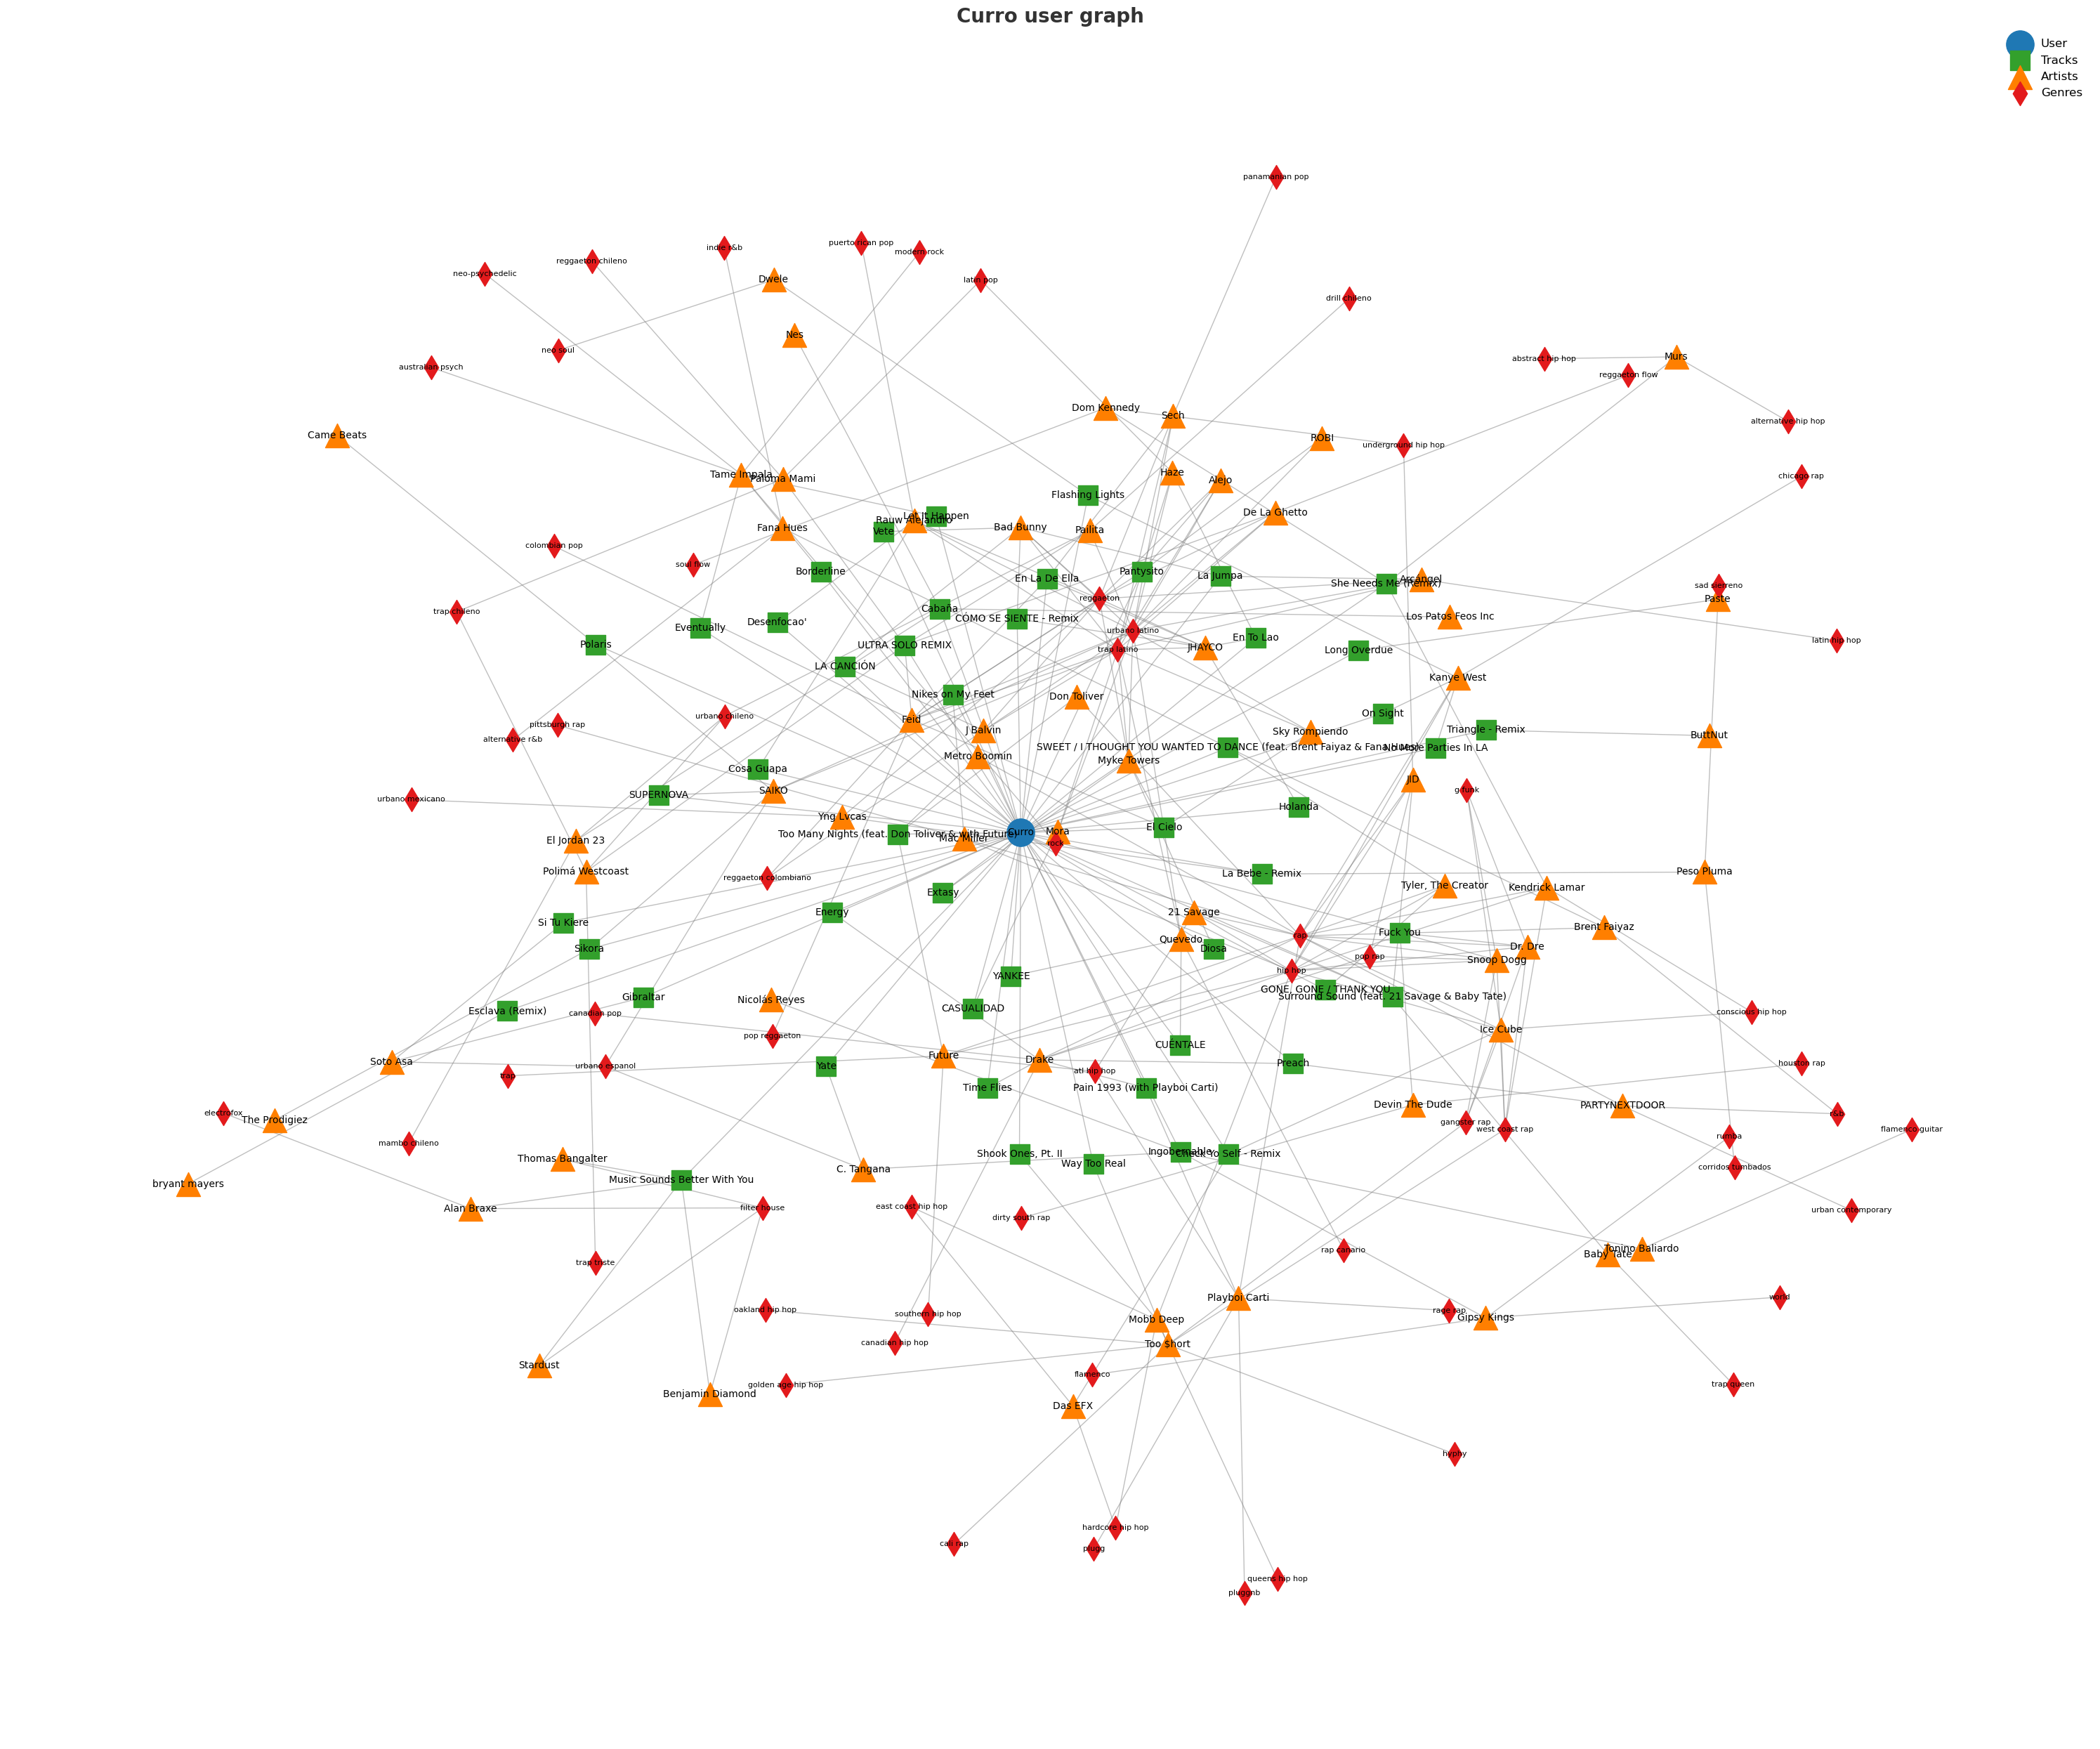

In [19]:
aux1 = usernames[0]
token1 = util.prompt_for_user_token(aux1, scope, client_id, client_secret, redirect_uri)
sp1 = spotipy.Spotify(auth=token1)
auth1 = {"Authorization": f"Bearer {token1}"}
G1, sets1 = build_user_graph(sp=sp1, username=aux1, auth_headers=auth1)
draw_user_graph(G1, f"{aux1} user graph")
#nx.write_graphml(G2, "grafo_{aux1}.graphml")

C:\Users\aleja\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38634 (\N{CJK UNIFIED IDEOGRAPH-96EA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\aleja\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


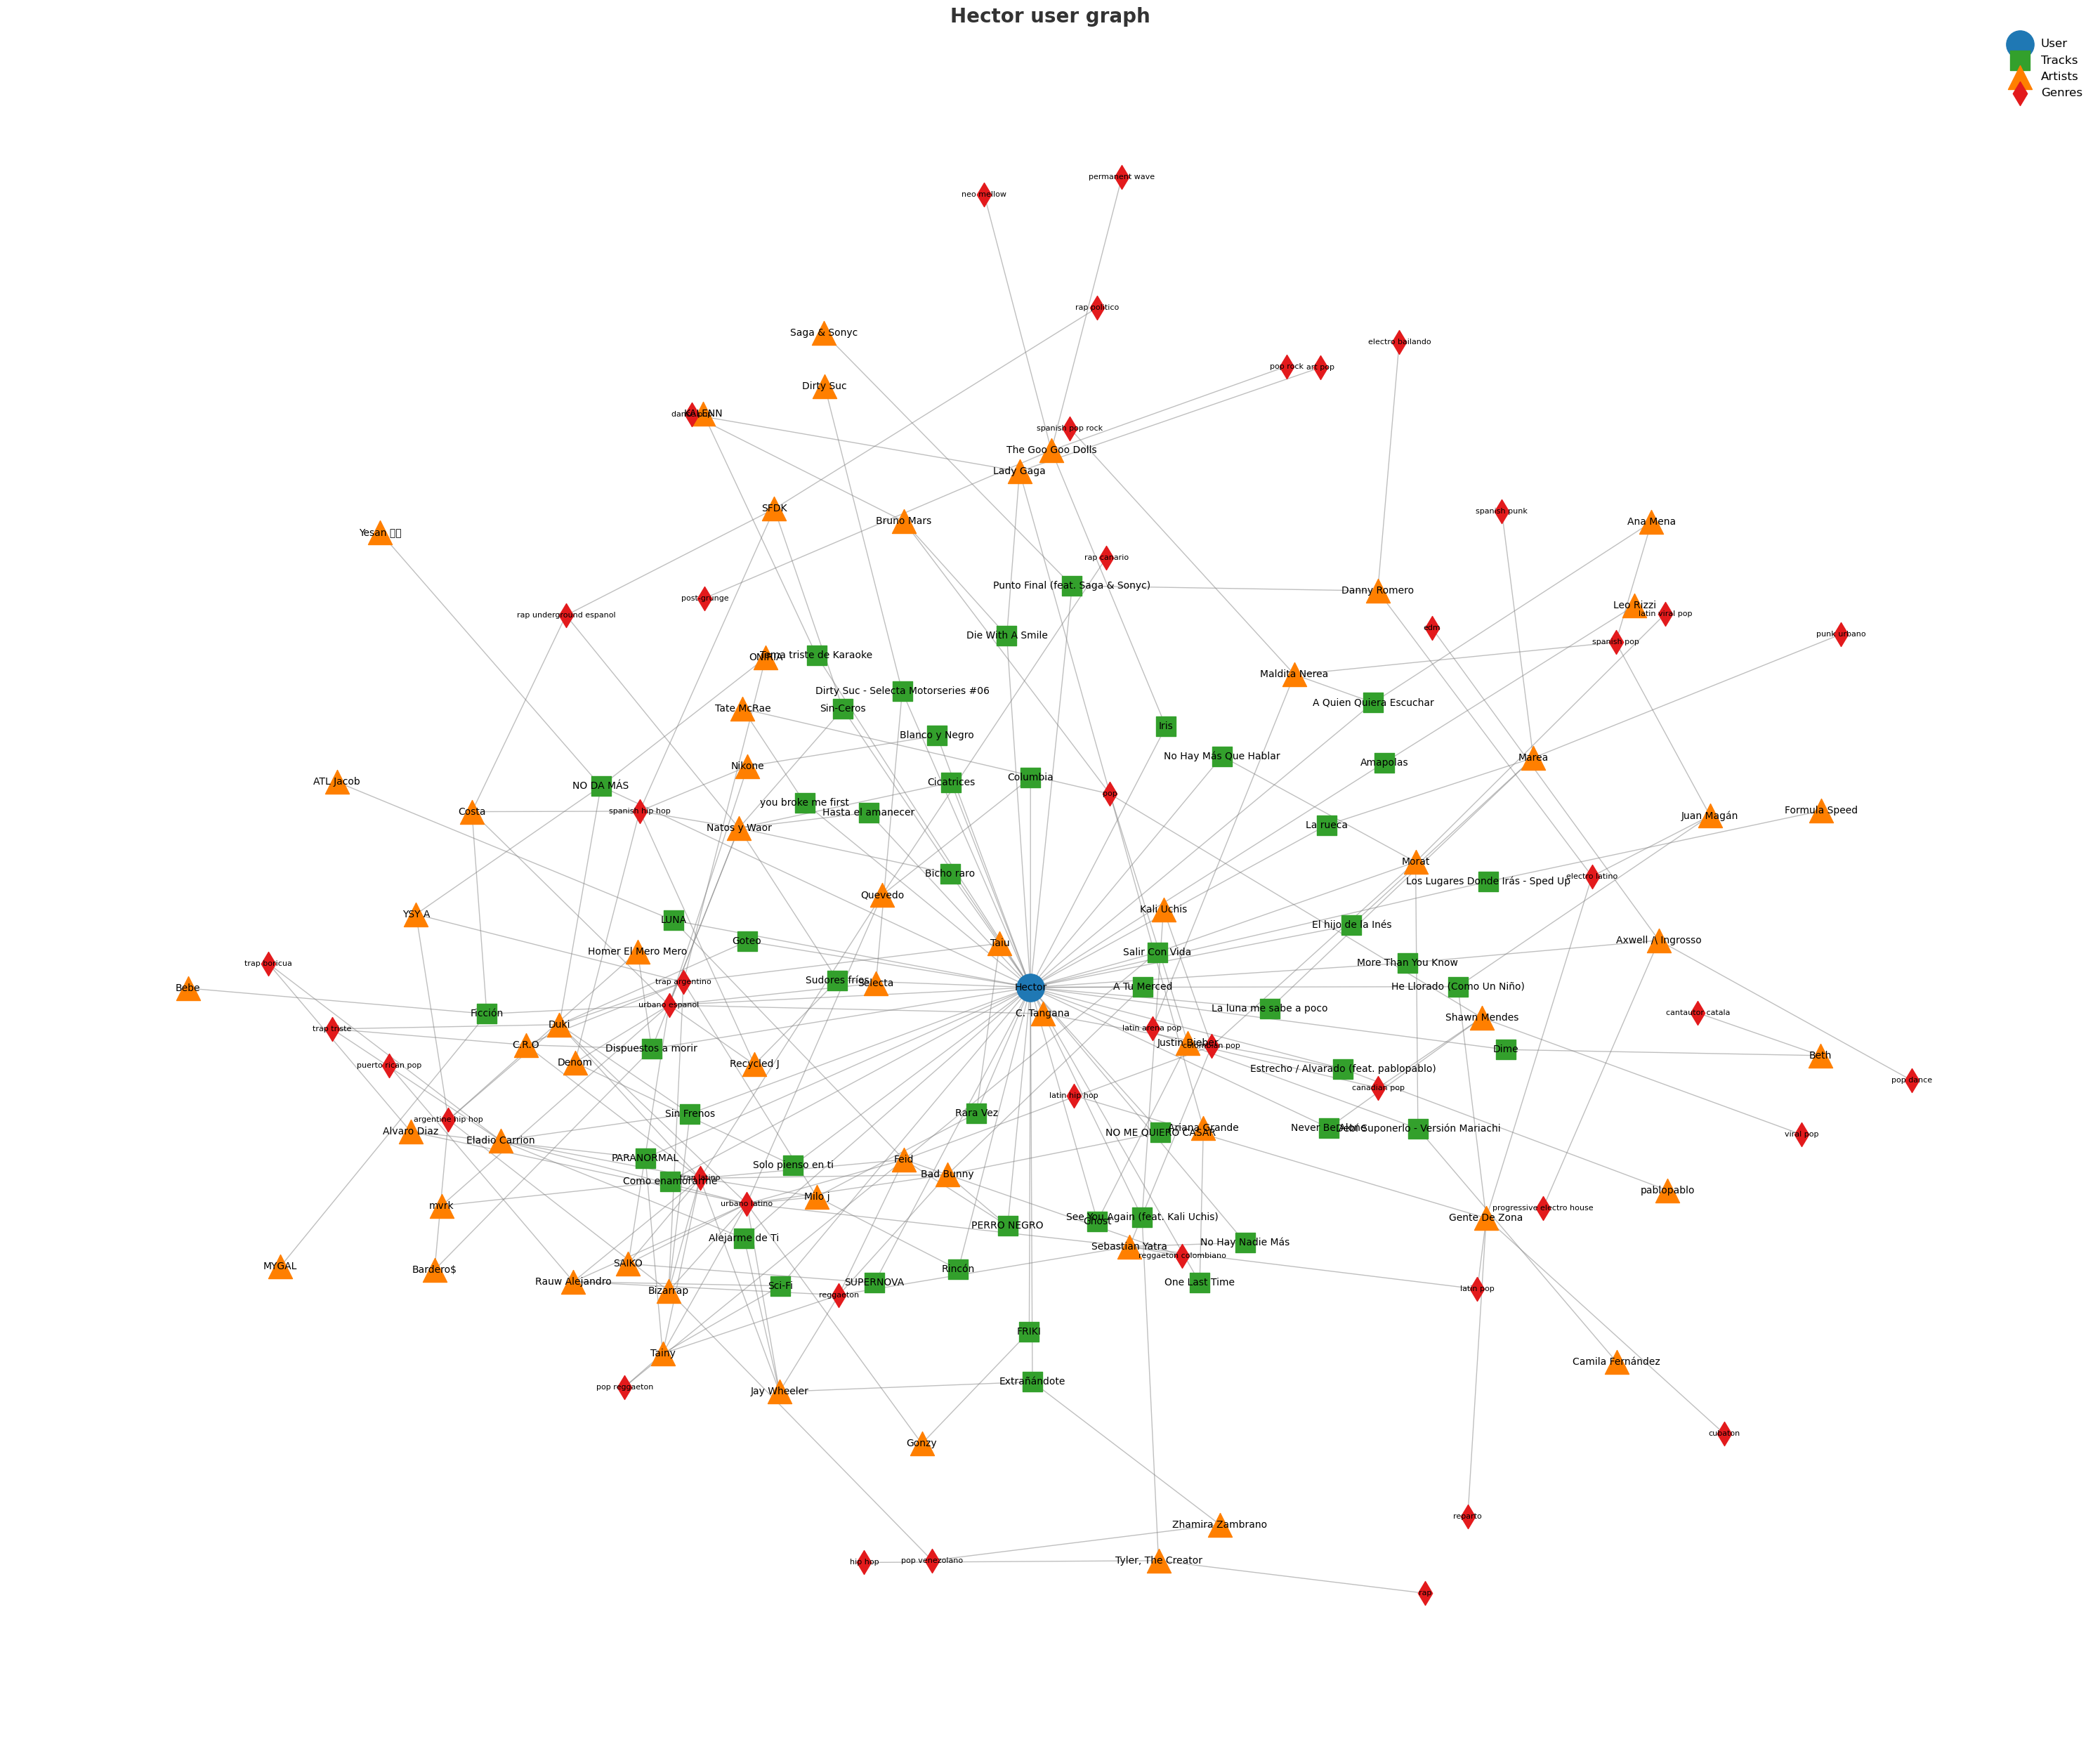

In [21]:
aux2 = usernames[3]
token2 = util.prompt_for_user_token(aux2, scope, client_id, client_secret, redirect_uri)
sp2 = spotipy.Spotify(auth=token2)
auth2 = {"Authorization": f"Bearer {token2}"}
G2, sets2 = build_user_graph(sp2, aux2, auth2)
draw_user_graph(G2, f"{aux2} user graph")
#nx.write_graphml(G2, "grafo_{aux2}.graphml")

# Results code

In [22]:
def results(G1, G2, user_1, user_2):    
    G_combined = integrate_graphs(G1, G2)

    common_tracks = sets1[0].intersection(sets2[0])
    common_artists = sets1[1].intersection(sets2[1])
    common_genres = sets1[2].intersection(sets2[2])
    
    total_tracks = len(sets1[0].union(sets2[0]))
    total_artists = len(sets1[1].union(sets2[1]))
    total_genres = len(sets1[2].union(sets2[2]))

    betweenness = nx.betweenness_centrality(G_combined)
    
    common_tracks_betweenness = [betweenness[node] for node in common_tracks if node in betweenness]
    common_artists_betweenness = [betweenness[node] for node in common_artists if node in betweenness]
    common_genres_betweenness = [betweenness[node] for node in common_genres if node in betweenness]
    
    common_tracks_betweenness_variance = np.var(common_tracks_betweenness) if common_tracks_betweenness else 0
    common_artists_betweenness_variance = np.var(common_artists_betweenness) if common_artists_betweenness else 0
    common_genres_betweenness_variance = np.var(common_genres_betweenness) if common_genres_betweenness else 0

    sorted_betweenness = dict(sorted(betweenness.items(), key=lambda item: item[1], reverse=True))
    #print(sorted_betweenness)

    tracks_sim = jaccard_similarity(sets1[0], sets2[0])
    artists_sim = jaccard_similarity(sets1[1], sets2[1])
    genres_sim = jaccard_similarity(sets1[2], sets2[2])

    tracks_factor = betweenness_variance_adjustance(common_tracks_betweenness_variance)
    artists_factor = betweenness_variance_adjustance(common_artists_betweenness_variance)
    genres_factor = betweenness_variance_adjustance(common_genres_betweenness_variance)

    tracks_weight = 0.1
    artists_weight = 0.2
    genres_weight = 0.7

    similarity_score = (tracks_weight * tracks_sim * tracks_factor) + \
                       (artists_weight * artists_sim * artists_factor) + \
                       (genres_weight * genres_sim * genres_factor)
    
    similarity_punctuation = round(similarity_score * 100, 0)
    inverse_logarithm_similarity_score =  (math.log(similarity_punctuation) / math.log(100)) * 100
    inverse_logarithm_similarity_punctuation =  round(inverse_logarithm_similarity_score, 0)

    print(f"Users: {user_1} & {user_2}")
    print("")
    print(f"Common tracks {len(common_tracks)} out of {total_tracks}: {common_tracks}")
    print(f"Tracks similarity: {tracks_sim}")
    print(f"Tracks betweeness correction factor: {tracks_factor}")
    print("")
    print(f"Common artists {len(common_artists)} out of {total_artists}: {common_artists}")
    print(f"Artists similarity: {artists_sim}")
    print(f"Artists betweeness correction factor: {artists_factor}")
    print("")
    print(f"Common genres {len(common_genres)} out of {total_genres}: {common_genres}")
    print(f"Genres similarity: {genres_sim}")
    print(f"Genres betweeness correction factor: {genres_factor}")
    print("")
    print(f"Similarity score: {similarity_score}")
    print(f"Similarity punctuation: {similarity_punctuation}%")
    print(f"IL-Similarity score: {inverse_logarithm_similarity_score}%")
    print(f"IL-Similarity puntuaction: {inverse_logarithm_similarity_punctuation}%")

In [23]:
results(G1,G2,aux1,aux2)

Users: Curro & Hector

Common tracks 1 out of 99: {'SUPERNOVA'}
Tracks similarity: 0.010101010101010102
Tracks betweeness correction factor: 1.0

Common artists 7 out of 116: {'SAIKO', 'Tyler, The Creator', 'Rauw Alejandro', 'Bad Bunny', 'C. Tangana', 'Feid', 'Quevedo'}
Artists similarity: 0.0603448275862069
Artists betweeness correction factor: 0.9997760512422984

Common genres 15 out of 97: {'reggaeton colombiano', 'urbano espanol', 'trap latino', 'rap canario', 'reggaeton', 'rap', 'trap triste', 'colombian pop', 'canadian pop', 'urbano latino', 'hip hop', 'latin hip hop', 'latin pop', 'pop reggaeton', 'puerto rican pop'}
Genres similarity: 0.15463917525773196
Genres betweeness correction factor: 0.9995952996939692

Similarity score: 0.12127997861283463
Similarity punctuation: 12.0%
IL-Similarity score: 53.959062302381234%
IL-Similarity puntuaction: 54.0%


# Excel creation functions

In [30]:
def build_excel(sp, username, auth_headers):

    all_tracks = get_user_top_tracks_or_playlists(sp, username)
    
    if not all_tracks:
        print(f"Error: {username}.")
        return None

    rows = []
    SPOTIFY_API_URL = "https://api.spotify.com/v1"
    EXCEL_FILENAME = f"{username}_tracks_artists_genres.xlsx"

    for track in all_tracks[:50]:
        track_name = track['name']

        for artist in track['artists']:
            artist_id = artist['id']
            artist_name = artist['name']

            artist_info = get_artist_info(artist_id, auth_headers)
            genres = artist_info.get('genres', ["No genre"])

            for genre in genres:
                rows.append([username, track_name, artist_name, genre])

    df = pd.DataFrame(rows, columns=["User", "Tracks", "Artists", "Genres"])
    df.to_excel(EXCEL_FILENAME, index=False)

    print(f"Excel saved{EXCEL_FILENAME}")

In [31]:
build_excel(sp1, aux1, auth1)

Excel savedCurro_tracks_artists_genres.xlsx


In [32]:
def save_results_to_excel_detailed(G1, G2, sets1, sets2, user_1, user_2, filename="user_similarity_results.xlsx"):

    G_combined = integrate_graphs(G1, G2)

    common_tracks = sets1[0].intersection(sets2[0])
    common_artists = sets1[1].intersection(sets2[1])
    common_genres = sets1[2].intersection(sets2[2])

    total_tracks = len(sets1[0].union(sets2[0]))
    total_artists = len(sets1[1].union(sets2[1]))
    total_genres = len(sets1[2].union(sets2[2]))

    betweenness = nx.betweenness_centrality(G_combined)

    common_tracks_betweenness = [betweenness[node] for node in common_tracks if node in betweenness]
    common_artists_betweenness = [betweenness[node] for node in common_artists if node in betweenness]
    common_genres_betweenness = [betweenness[node] for node in common_genres if node in betweenness]

    tracks_sim = jaccard_similarity(sets1[0], sets2[0])
    artists_sim = jaccard_similarity(sets1[1], sets2[1])
    genres_sim = jaccard_similarity(sets1[2], sets2[2])

    tracks_factor = betweenness_variance_adjustance(np.var(common_tracks_betweenness) if common_tracks_betweenness else 0)
    artists_factor = betweenness_variance_adjustance(np.var(common_artists_betweenness) if common_artists_betweenness else 0)
    genres_factor = betweenness_variance_adjustance(np.var(common_genres_betweenness) if common_genres_betweenness else 0)

    tracks_weight = 0.1
    artists_weight = 0.2
    genres_weight = 0.7

    similarity_score = (tracks_weight * tracks_sim * tracks_factor) + \
                       (artists_weight * artists_sim * artists_factor) + \
                       (genres_weight * genres_sim * genres_factor)

    similarity_punctuation = round(similarity_score * 100, 0)
    inverse_logarithm_similarity_score = (np.log(similarity_punctuation) / np.log(100)) * 100 if similarity_punctuation > 0 else 0
    inverse_logarithm_similarity_punctuation = round(inverse_logarithm_similarity_score, 0)

    #Create a Dataframe
    max_len = max(len(common_tracks), len(common_artists), len(common_genres))
    data = {
        "User Pair": [f"{user_1} & {user_2}"] + [np.nan] * (max_len - 1),
        "Common Tracks": list(common_tracks) + [np.nan] * (max_len - len(common_tracks)),
        "Common Artists": list(common_artists) + [np.nan] * (max_len - len(common_artists)),
        "Common Genres": list(common_genres) + [np.nan] * (max_len - len(common_genres)),
        "Total Tracks": [total_tracks] + [np.nan] * (max_len - 1),
        "Total Artists": [total_artists] + [np.nan] * (max_len - 1),
        "Total Genres": [total_genres] + [np.nan] * (max_len - 1),
        "Tracks Similarity": [tracks_sim] + [np.nan] * (max_len - 1),
        "Artists Similarity": [artists_sim] + [np.nan] * (max_len - 1),
        "Genres Similarity": [genres_sim] + [np.nan] * (max_len - 1),
        "Tracks Betweeness Factor": [tracks_factor] + [np.nan] * (max_len - 1),
        "Artists Betweeness Factor": [artists_factor] + [np.nan] * (max_len - 1),
        "Genres Betweeness Factor": [genres_factor] + [np.nan] * (max_len - 1),
        "Similarity Score": [similarity_score] + [np.nan] * (max_len - 1),
        "Similarity Punctuation": [similarity_punctuation] + [np.nan] * (max_len - 1),
        "IL-Similarity Score": [inverse_logarithm_similarity_score] + [np.nan] * (max_len - 1),
        "IL-Similarity Punctuation": [inverse_logarithm_similarity_punctuation] + [np.nan] * (max_len - 1),
    }

    df = pd.DataFrame(data)
    df.to_excel(filename, index=False)
    print(f"Excel saved: {filename}")

In [33]:
save_results_to_excel_detailed(G1, G2, sets1, sets2, aux1, aux2)

Excel saved: user_similarity_results.xlsx


# Results auxiliar prints

## Similarity index

In [ ]:
'''
tracks_weight = 0.1
artists_weight = 0.2
genres_weight = 0.7
'''
'''
Users: Curro & Amaia

Common tracks 0 out of 100: set()
Tracks similarity: 0.0
Tracks betweeness correction factor: 1.0

Common artists 1 out of 107: {'Bad Bunny'}
Artists similarity: 0.009345794392523364
Artists betweeness correction factor: 1.0

Common genres 12 out of 123: {'modern_rock', 'alternative_r&b', 'reggaeton', 'urbano_espanol', 'urbano_chileno', 'flamenco', 'trap_chileno', 'r&b', 'rap', 'urbano_latino', 'rock', 'trap_latino'}
Genres similarity: 0.0975609756097561
Genres betweeness correction factor: 0.9988597175102246

Similarity score: 0.07008396885481268
Similarity punctuation: 7.0%
IL-Similarity score: 42.25490200071283%
IL-Similarity puntuaction: 42.0%
'''
'''
Users: Curro & Silvina

Common tracks 0 out of 98: set()
Tracks similarity: 0.0
Tracks betweeness correction factor: 1.0

Common artists 0 out of 114: set()
Artists similarity: 0.0
Artists betweeness correction factor: 1.0

Common genres 4 out of 94: {'latin hip hop', 'urbano latino', 'puerto rican pop', 'latin pop'}
Genres similarity: 0.0425531914893617
Genres betweeness correction factor: 0.9856819657445397

Similarity score: 0.0293607394051565
Similarity punctuation: 3.0%
IL-Similarity score: 23.856062735983123%
IL-Similarity puntuaction: 24.0%
'''
'''
Users: Curro & Hector

Common tracks 1 out of 99: {'SUPERNOVA'}
Tracks similarity: 0.010101010101010102
Tracks betweeness correction factor: 1.0

Common artists 7 out of 116: {'SAIKO', 'C. Tangana', 'Quevedo', 'Feid', 'Tyler, The Creator', 'Bad Bunny', 'Rauw Alejandro'}
Artists similarity: 0.0603448275862069
Artists betweeness correction factor: 1.0

Common genres 15 out of 97: {'latin_hip_hop', 'rap_canario', 'reggaeton_colombiano', 'reggaeton', 'urbano_espanol', 'colombian_pop', 'trap_triste', 'pop_reggaeton', 'puerto_rican_pop', 'canadian_pop', 'rap', 'urbano_latino', 'hip_hop', 'latin_pop', 'trap_latino'}
Genres similarity: 0.15463917525773196
Genres betweeness correction factor: 0.9995952996939692

Similarity score: 0.12128268144266896
Similarity punctuation: 12.0%
IL-Similarity score: 53.959062302381234%
IL-Similarity puntuaction: 54.0%
'''
'''
Users: Curro & Nicolás

Common tracks 0 out of 100: set()
Tracks similarity: 0.0
Tracks betweeness correction factor: 1.0

Common artists 3 out of 125: {'Quevedo', 'Mora', 'Myke Towers'}
Artists similarity: 0.024
Artists betweeness correction factor: 0.9994704373869293

Common genres 20 out of 114: {'chicago rap', 'urbano chileno', 'reggaeton colombiano', 'reggaeton', 'southern hip hop', 'canadian hip hop', 'trap', 'atl hip hop', 'hip hop', 'trap triste', 'trap chileno', 'pop rap', 'trap latino', 'plugg', 'gangster rap', 'underground hip hop', 'rap canario', 'r&b', 'urbano latino', 'rap'}
Genres similarity: 0.17543859649122806
Genres betweeness correction factor: 0.9989347113563514

Similarity score: 0.12747365072216704
Similarity punctuation: 13.0%
IL-Similarity score: 55.69716761534183%
IL-Similarity puntuaction: 56.0%
'''
'''
Users: Amaia & Silvina

Common tracks 0 out of 98: set()
Tracks similarity: 0.0
Tracks betweeness correction factor: 1.0

Common artists 0 out of 94: set()
Artists similarity: 0.0
Artists betweeness correction factor: 1.0

Common genres 3 out of 94: {'rap conciencia', 'urbano latino', 'tontipop'}
Genres similarity: 0.031914893617021274
Genres betweeness correction factor: 0.9839992503122581

Similarity score: 0.021982961975061083
Similarity punctuation: 2.0%
IL-Similarity score: 15.051499783199057%
IL-Similarity puntuaction: 15.0%
'''
'''
Users: Amaia & Hector

Common tracks 0 out of 100: set()
Tracks similarity: 0.0
Tracks betweeness correction factor: 1.0

Common artists 1 out of 102: {'Bad Bunny'}
Artists similarity: 0.00980392156862745
Artists betweeness correction factor: 1.0

Common genres 11 out of 100: {'art pop', 'pop', 'neo mellow', 'rap', 'latin viral pop', 'trap latino', 'reggaeton', 'rap politico', 'urbano latino', 'viral pop', 'urbano espanol'}
Genres similarity: 0.11
Genres betweeness correction factor: 0.9990111771695025

Similarity score: 0.07888464495577718
Similarity punctuation: 8.0%
IL-Similarity score: 45.154499349597174%
IL-Similarity puntuaction: 45.0%
'''
'''
Users: Amaia & Nicolás

Common tracks 0 out of 100: set()
Tracks similarity: 0.0
Tracks betweeness correction factor: 1.0

Common artists 0 out of 108: set()
Artists similarity: 0.0
Artists betweeness correction factor: 1.0

Common genres 13 out of 120: {'trap chileno', 'progressive house', 'pop', 'urbano chileno', 'house', 'trap latino', 'reggaeton', 'r&b', 'urbano latino', 'pov: indie', 'uk dance', 'viral pop', 'rap'}
Genres similarity: 0.10833333333333334
Genres betweeness correction factor: 0.9974945115569536

Similarity score: 0.07564333379306898
Similarity punctuation: 8.0%
IL-Similarity score: 45.154499349597174%
IL-Similarity puntuaction: 45.0%
'''
'''
Users: Silvina & Hector

Common tracks 0 out of 98: set()
Tracks similarity: 0.0
Tracks betweeness correction factor: 1.0

Common artists 0 out of 109: set()
Artists similarity: 0.0
Artists betweeness correction factor: 1.0

Common genres 9 out of 65: {'spanish pop', 'latin pop', 'spanish hip hop', 'spanish pop rock', 'latin arena pop', 'urbano latino', 'latin hip hop', 'cantautor catala', 'puerto rican pop'}
Genres similarity: 0.13846153846153847
Genres betweeness correction factor: 0.9956834217413257

Similarity score: 0.09650470087646695
Similarity punctuation: 10.0%
IL-Similarity score: 50.0%
IL-Similarity puntuaction: 50.0%
'''
'''
Users: Silvina & Nicolás

Common tracks 0 out of 98: set()
Tracks similarity: 0.0
Tracks betweeness correction factor: 1.0

Common artists 0 out of 114: set()
Artists similarity: 0.0
Artists betweeness correction factor: 1.0

Common genres 1 out of 95: {'urbano latino'}
Genres similarity: 0.010526315789473684
Genres betweeness correction factor: 1.0

Similarity score: 0.007368421052631578
Similarity punctuation: 1.0%
IL-Similarity score: 0.0%
IL-Similarity puntuaction: 0.0%
'''
'''
Users: Hector & Nicolás

Common tracks 1 out of 99: {'Rara Vez'}
Tracks similarity: 0.010101010101010102
Tracks betweeness correction factor: 1.0

Common artists 3 out of 120: {'Quevedo', 'Milo j', 'Taiu'}
Artists similarity: 0.025
Artists betweeness correction factor: 1.0

Common genres 15 out of 95: {'rap_canario', 'reggaeton_colombiano', 'reggaeton', 'pop_dance', 'trap_triste', 'dance_pop', 'pop', 'edm', 'trap_argentino', 'rap', 'progressive_electro_house', 'urbano_latino', 'hip_hop', 'trap_latino', 'viral_pop'}
Genres similarity: 0.15789473684210525
Genres betweeness correction factor: 0.9997569885447557

Similarity score: 0.11650955763873189
Similarity punctuation: 12.0%
IL-Similarity punctuation: 53.959062302381234%
'''
'''
Users: Maria & Amaia

Common tracks 0 out of 100: set()
Tracks similarity: 0.0
Tracks betweeness correction factor: 1.0

Common artists 0 out of 96: set()
Artists similarity: 0.0
Artists betweeness correction factor: 1.0

Common genres 9 out of 119: {'modern_rock', 'pop', 'metropopolis', 'uk_pop', 'rap', 'rock', 'indietronica', 'art_pop', 'viral_pop'}
Genres similarity: 0.07563025210084033
Genres betweeness correction factor: 0.9904336655056567

Similarity score: 0.052434723467946524
Similarity punctuation: 5.0%
IL-Similarity score: 34.94850021680094%
IL-Similarity puntuaction: 35.0%
'''

## Similarity index - time version

In [ ]:
'''
Users: Silvina short & Silvina medium

Common tracks 10 out of 89: {'Cerca del Invierno', 'Se fuerza la máquina - Nueva mezcla 2024', 'Cariño, suéltate el pelo', 'La Torre Picasso', 'Todo cambia', 'Que nada nos pare (lo más importante)', 'Un Día Más (de Septiembre)', 'Me has invitado a bailar', 'Matar la Pena', 'Dime Solo Si Has Pensao'}
Tracks similarity: 0.11235955056179775
Tracks betweeness correction factor: 0.9999555201072481

Common artists 12 out of 57: {'Arde Bogotá', 'DePol', 'Dani Fernández', 'Enrique Urquijo y Los problemas', 'Samuraï', 'ELYELLA', 'Malmö 040', 'Siloé', 'Mikel Izal', 'Besmaya', 'MERINO', 'La La Love You'}
Artists similarity: 0.21052631578947367
Artists betweeness correction factor: 0.9998590290933923

Common genres 11 out of 30: {'spanish pop', 'spanish modern rock', 'tontipop', 'cantautor', 'spanish rock', 'spanish new wave', 'latin arena pop', 'murcia indie', 'spanish pop rock', 'spanish folk rock', 'spanish indie pop'}
Genres similarity: 0.36666666666666664
Genres betweeness correction factor: 0.9980769231465048

Similarity score: 0.30950785976381456
Similarity punctuation: 31.0%
IL-Similarity score: 74.56808469171364%
IL-Similarity puntuaction: 75.0%
'''
'''
Users: Silvina short & Silvina long

Common tracks 4 out of 94: {'El Principio de algo', 'Que nada nos pare (lo más importante)', 'Viaje Sin Vuelta', 'Todos los Besos'}
Tracks similarity: 0.0425531914893617
Tracks betweeness correction factor: 0.9999848272120893

Common artists 8 out of 72: {'Arde Bogotá', 'Pol 3.14', 'Paula Mattheus', 'Dani Fernández', 'Samuraï', 'ELYELLA', 'Siloé', 'La La Love You'}
Artists similarity: 0.1111111111111111
Artists betweeness correction factor: 0.9999291279308172

Common genres 13 out of 36: {'spanish pop', 'spanish modern rock', 'tontipop', 'spanish synthpop', 'cantautor', 'spanish rock', 'spanish new wave', 'spanish hip hop', 'murcia indie', 'spanish pop rock', 'latin rock', 'latin arena pop', 'spanish indie pop'}
Genres similarity: 0.3611111111111111
Genres betweeness correction factor: 0.9993208349347019

Similarity score: 0.27908200181306014
Similarity punctuation: 28.0%
IL-Similarity score: 72.35790156711094%
IL-Similarity puntuaction: 72.0%
'''
'''
Users: Silvina medium & Silvina long

Common tracks 4 out of 93: {'Sin Vergüenza', 'Que nada nos pare (lo más importante)', 'La Salvación', 'Lo Siento'}
Tracks similarity: 0.043010752688172046
Tracks betweeness correction factor: 0.9999964331490432

Common artists 8 out of 81: {'Arde Bogotá', 'Dani Fernández', 'Viva Suecia', 'Samuraï', 'ELYELLA', 'Siloé', 'Shinova', 'La La Love You'}
Artists similarity: 0.09876543209876543
Artists betweeness correction factor: 0.9999363545866595

Common genres 12 out of 40: {'spanish pop', 'spanish modern rock', 'latin pop', 'tontipop', 'cantautor', 'spanish rock', 'spanish new wave', 'rock alternativo espanol', 'murcia indie', 'spanish pop rock', 'latin arena pop', 'spanish indie pop'}
Genres similarity: 0.3
Genres betweeness correction factor: 0.99927268846062

Similarity score: 0.23390015373065612
Similarity punctuation: 23.0%
IL-Similarity score: 68.08639180087964%
IL-Similarity puntuaction: 68.0%
'''

# Deprecated code

In [ ]:
# Pattern Metric Computation
'''
def calculate_similarity_score_connections(G_combined, user_node_1, user_node_2, paths_2, paths_4, paths_6):
    """
    Calculates the similarity metric between two users based on the combined graph 
    and the list of paths for each pattern (2, 4, and 6 steps).
    """

    # Assign weights to each pattern type
    weights = {
        2: 8.0,  # Path involving tracks
        4: 5.0,  # Path involving artists
        6: 0.1   # Path involving genres
    }

    # Calculate the shortest path between the two user nodes
    try:
        shortest_path = nx.shortest_path(G_combined, user_node_1, user_node_2)
        shortest_length = len(shortest_path) - 1
    except nx.NetworkXNoPath:
        shortest_length = float('inf')

    # Determine the total number of shortest paths in the graph
    if shortest_length != float('inf'):
        num_shortest_paths = len(list(nx.all_shortest_paths(G_combined, user_node_1, user_node_2)))
    else:
        num_shortest_paths = 0

    # Store the count of paths for each pattern in a dictionary
    pattern_lengths = {
        2: len(paths_2),
        4: len(paths_4),
        6: len(paths_6)
    }

    # Determine the number of shortest paths based on the shortest pattern length
    if shortest_length in pattern_lengths:
        shortest_paths_count = pattern_lengths[shortest_length]
    else:
        shortest_paths_count = 0

    # Calculate longer paths: paths that have more steps than the shortest path length
    longer_paths_counts = {pl: cnt for pl, cnt in pattern_lengths.items() if pl > shortest_length}

    # Compute the similarity score by summing weighted contributions for each pattern
    similarity_score = sum(count * weights.get(path_length, 0) for path_length, count in pattern_lengths.items())

    return {
        "shortest_length": shortest_length if shortest_length != float('inf') else None,
        "shortest_paths_count": shortest_paths_count,
        "longer_paths_counts": longer_paths_counts,  # Dictionary with counts of longer paths
        "similarity_score": similarity_score,
        "num_shortest_paths": num_shortest_paths
    }
'''

In [ ]:
# Limited simple paths Metric
'''
# Pattern for 6 steps: user->track->artist->genre->artist->track->user
pattern_6 = ['user', 'track', 'artist', 'genre', 'artist', 'track', 'user']
# Pattern for 4 steps: user->track->artist->track->user
pattern_4 = ['user', 'track', 'artist', 'track', 'user']
# Pattern for 2 steps: user->track->user
pattern_2 = ['user', 'track', 'user']

# Find paths for each pattern
paths_6 = find_paths_with_pattern(G_combined, aux1, aux2, pattern_6)
paths_4 = find_paths_with_pattern(G_combined, aux1, aux2, pattern_4)
paths_2 = find_paths_with_pattern(G_combined, aux1, aux2, pattern_2)

# Store path lengths for each pattern in a dictionary
pattern_lengths = {2: len(paths_2), 4: len(paths_4), 6: len(paths_6)}

# Calculate results
results = calculate_similarity_score_connections(G_combined, user_node_1, user_node_2, paths_2, paths_4, paths_6)

# Dynamic printing
print("Shortest path length:", results["shortest_length"] if results["shortest_length"] is not None else "No path")

# Print the shortest paths for the shortest pattern length
if results["shortest_length"] is not None:
    print(f"Number of paths with {results['shortest_length']} steps (Shortest Path):", results["shortest_paths_count"])

# Print longer paths if they exist
if results["longer_paths_counts"]:
    for pl, count in sorted(results["longer_paths_counts"].items()):
        print(f"Number of Longer paths with ({pl} steps):", count)

print("Overall similarity score:", results["similarity_score"])
'''

In [ ]:
# Shortest path visualization
'''
# Visualization of the shortest paths
if results["shortest_length"] is not None:
    # Retrieve all shortest paths between the two user nodes
    shortest_paths = list(nx.all_shortest_paths(G_combined, user_node_1, user_node_2))
else:
    # No shortest path exists
    shortest_paths = []

# Define colors for paths
colors = itertools.cycle(["red", "blue", "green", "orange", "purple", "cyan"])
# Calculate layout for graph visualization
pos = nx.spring_layout(G_combined, k=0.3, seed=42)

# Create figure
plt.figure(figsize=(16, 12))

# Draw all nodes in the graph
nx.draw_networkx_nodes(G_combined, pos, node_size=100, node_color="gray")

# Draw all edges in the graph with transparency
nx.draw_networkx_edges(G_combined, pos, alpha=0.2)

# Highlight each shortest path with a distinct color
for path, color in zip(shortest_paths, colors):
    path_edges = list(zip(path, path[1:]))  # Pair nodes in the path to create edges
    nx.draw_networkx_edges(G_combined, pos, edgelist=path_edges, edge_color=color, width=2, label=f'Path {color}')

# Add labels to nodes involved in the shortest paths
if shortest_paths:
    labels = {n: G_combined.nodes[n]['name'] for n in set(itertools.chain(*shortest_paths)) if 'name' in G_combined.nodes[n]}
    nx.draw_networkx_labels(G_combined, pos, labels=labels, font_size=8)

# Set plot title and legend
plt.title("Combined Graph with Highlighted Shortest Paths", fontsize=20)
plt.legend(scatterpoints=1, loc="upper right", fontsize=10, frameon=False)
plt.axis("off")
plt.tight_layout()  # Adjust layout
plt.show()
'''

In [ ]:
# Check API status Version
'''
def get_artist_info(artist_id, auth_headers):
    """
    Retrieve artist information from the Spotify API.
    Returns a dictionary with artist information, including genres.
    """
    SPOTIFY_API_URL = "https://api.spotify.com/v1"
    url = f"{SPOTIFY_API_URL}/artists/{artist_id}"
    resp = requests.get(url, headers=auth_headers)

    if resp.status_code == 200:
        data = resp.json()
        # Ensure that 'genres' is included in the response
        return data
    else:
        # Log the error for debugging
        print(f"Error fetching artist info for {artist_id}. Status code: {resp.status_code}")
        return {}
'''

In [ ]:
# Web Scrapping Version
'''
import requests
from bs4 import BeautifulSoup
import networkx as nx

def get_artist_genres_via_scraping(artist_url):

    try:
        response = requests.get(artist_url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        
        genres_section = soup.find_all("span", class_="genre-class")
        genres = [genre.get_text(strip=True) for genre in genres_section]
        
        if not genres:
            print(f"Error: {artist_url}")
        return genres
    except Exception as e:
        print(f"Error: {artist_url}: {e}")
        return []


def build_user_graph(sp, username, auth_headers, limit=50):
    all_tracks = get_user_top_tracks_or_playlists(sp, username, limit=limit)
    
    if not all_tracks:
        print(f"No tracks or playlists found for {username}.")
        G = nx.Graph()
        G.add_node(f"user:{username}", type='user', name=username)
        return G, (set(), set(), set())

    G = nx.Graph()
    user_node = f"user:{username}"
    G.add_node(user_node, type='user', name=username)

    set_tracks, set_artists, set_genres = set(), set(), set()

    for track in all_tracks[:limit]:
        track_id = track['id']
        track_name = track['name']
        G.add_node(track_id, type='track', name=track_name)
        G.add_edge(user_node, track_id)
        set_tracks.add(track_id)

        for artist in track['artists']:
            artist_id = artist['id']
            artist_name = artist['name']
            artist_url = artist['external_urls']['spotify']
            G.add_node(artist_id, type='artist', name=artist_name, url=artist_url)
            G.add_edge(track_id, artist_id)
            set_artists.add(artist_id)

            genres = get_artist_genres_via_scraping(artist_url)
            for genre in genres:
                genre_node = f"genre:{genre.lower().replace(' ', '_')}"
                if genre_node not in G:
                    G.add_node(genre_node, type='genre', name=genre.title())
                G.add_edge(artist_id, genre_node)
                set_genres.add(genre_node)

    return G, (set_tracks, set_artists, set_genres)
'''

In [29]:
# Find paths
'''
def find_paths_with_pattern(G, start, end, pattern):
    """
    Finds all paths between start and end nodes that match a specific node type pattern.
    The pattern is a list of node types, for example:
    ['user', 'track', 'artist', 'genre', 'artist', 'track', 'user'] for a 6-step path.
    
    The length of the pattern in nodes is (number of steps + 1).
    """
    all_paths = []

    def dfs(current_node, depth, path):
        # If we have reached the length of the pattern
        if depth == len(pattern) - 1:
            # Check if the current node is the destination
            if current_node == end:
                all_paths.append(path[:])
            return

        # Iterate through neighbors
        for neighbor in G.neighbors(current_node):
            # Check if the type of the next neighbor matches the expected type in the pattern
            node_type = G.nodes[neighbor].get('type')
            if node_type == pattern[depth + 1]:
                path.append(neighbor)
                dfs(neighbor, depth + 1, path)
                path.pop()

    # Verify that the start and end node types match the pattern
    if G.nodes[start].get('type') != pattern[0] or G.nodes[end].get('type') != pattern[-1]:
        return all_paths

    # Start DFS
    dfs(start, 0, [start])
    return all_paths
'''

In [ ]:
# Old weights
'''
tracks_weight = 0.4
artists_weight = 0.4
genres_weight = 0.2
'''
'''
Users: Curro & Amaia
 Common tracks: set()
 Common artists: {'Bad Bunny'}
 Common genres: {'trap_chileno', 'rock', 'flamenco', 'trap_latino', 'r&b', 'alternative_r&b', 'urbano_chileno', 'urbano_espanol', 'urbano_latino', 'rap', 'modern_rock', 'reggaeton'}
 Tracks similarity: 0.0
 Tracks betweeness correction factor: 1.0
 Artists similarity: 0.009345794392523364
 Artists betweeness correction factor: 1.0
 Genres similarity: 0.0975609756097561
 Genres betweeness correction factor: 0.9988597175102246
 Similarity score: 0.023228263464525927
'''
'''
Users: Curro & Silvina
 Common tracks: set()
 Common artists: set()
 Common genres: {'latin_hip_hop', 'urbano_latino', 'puerto_rican_pop', 'latin_pop'}
 Tracks similarity: 0.0
 Tracks betweeness correction factor: 1.0
 Artists similarity: 0.0
 Artists betweeness correction factor: 1.0
 Genres similarity: 0.0425531914893617
 Genres betweeness correction factor: 0.9855325137496265
 Similarity score: 0.00838751075531597
'''
'''
Users: Curro & Hector
 Common tracks: {'SUPERNOVA'}
 Common artists: {'Tyler, The Creator', 'C. Tangana', 'Bad Bunny', 'Quevedo', 'SAIKO', 'Rauw Alejandro', 'Feid'}
 Common genres: {'hip_hop', 'pop_reggaeton', 'rap_canario', 'trap_triste', 'trap_latino', 'colombian_pop', 'latin_pop', 'latin_hip_hop', 'urbano_espanol', 'canadian_pop', 'puerto_rican_pop', 'urbano_latino', 'rap', 'reggaeton_colombiano', 'reggaeton'}
 Tracks similarity: 0.010101010101010102
 Tracks betweeness correction factor: 1.0
 Artists similarity: 0.0603448275862069
 Artists betweeness correction factor: 1.0
 Genres similarity: 0.15463917525773196
 Genres betweeness correction factor: 0.9995952996939692
 Similarity score: 0.05909365362212297
'''
'''
Users: Curro & Nicolás
 Common tracks: set()
 Common artists: {'Quevedo', 'Myke Towers', 'Mora'}
 Common genres: {'underground_hip_hop', 'reggaeton', 'chicago_rap', 'plugg', 'urbano_latino', 'rap_canario', 'pop_rap', 'trap', 'trap_chileno', 'trap_latino', 'canadian_hip_hop', 'atl_hip_hop', 'gangster_rap', 'rap', 'southern_hip_hop', 'urbano_chileno', 'reggaeton_colombiano', 'trap_triste', 'r&b', 'hip_hop'}
 Tracks similarity: 0.0
 Tracks betweeness correction factor: 1.0
 Artists similarity: 0.024
 Artists betweeness correction factor: 1.0
 Genres similarity: 0.17543859649122806
 Genres betweeness correction factor: 0.9989347113563514
 Similarity score: 0.044650340749345666
 '''
'''
Users: Amaia & Silvina
 Common tracks: set()
 Common artists: set()
 Common genres: {'rap_conciencia', 'urbano_latino', 'tontipop'}
 Tracks similarity: 0.0
 Tracks betweeness correction factor: 1.0
 Artists similarity: 0.0
 Artists betweeness correction factor: 1.0
 Genres similarity: 0.031914893617021274
 Genres betweeness correction factor: 0.9827978650711338
 Similarity score: 0.006273177862156172
'''
'''
Users: Amaia & Hector
 Common tracks: set()
 Common artists: {'Bad Bunny'}
 Common genres: {'neo_mellow', 'reggaeton', 'urbano_espanol', 'pop', 'latin_viral_pop', 'rap', 'urbano_latino', 'art_pop', 'rap_politico', 'trap_latino', 'viral_pop'}
 Tracks similarity: 0.0
 Tracks betweeness correction factor: 1.0
 Artists similarity: 0.00980392156862745
 Artists betweeness correction factor: 1.0
 Genres similarity: 0.11
 Genres betweeness correction factor: 0.9990111771695025
 Similarity score: 0.02589981452518004
'''
'''
Users: Amaia & Nicolás
 Common tracks: set()
 Common artists: set()
 Common genres: {'progressive_house', 'reggaeton', 'urbano_chileno', 'uk_dance', 'pov:_indie', 'house', 'pop', 'trap_chileno', 'r&b', 'rap', 'urbano_latino', 'trap_latino', 'viral_pop'}
 Tracks similarity: 0.0
 Tracks betweeness correction factor: 1.0
 Artists similarity: 0.0
 Artists betweeness correction factor: 1.0
 Genres similarity: 0.10833333333333334
 Genres betweeness correction factor: 0.9974945115569536
 Similarity score: 0.021612381083733995
'''
'''
Users: Silvina & Hector
 Common tracks: set()
 Common artists: set()
 Common genres: {'latin_hip_hop', 'spanish_pop_rock', 'puerto_rican_pop', 'spanish_hip_hop', 'urbano_latino', 'latin_pop', 'latin_arena_pop', 'spanish_pop', 'cantautor_catala'}
 Tracks similarity: 0.0
 Tracks betweeness correction factor: 1.0
 Artists similarity: 0.0
 Artists betweeness correction factor: 1.0
 Genres similarity: 0.13846153846153847
 Genres betweeness correction factor: 0.9956404208623676
 Similarity score: 0.027571580885419413
'''
'''
Users: Silvina & Nicolás
 Common tracks: set()
 Common artists: set()
 Common genres: {'urbano_latino'}
 Tracks similarity: 0.0
 Tracks betweeness correction factor: 1.0
 Artists similarity: 0.0
 Artists betweeness correction factor: 1.0
 Genres similarity: 0.010526315789473684
 Genres betweeness correction factor: 1.0
 Similarity score: 0.002105263157894737
'''
'''
Users: Hector & Nicolás
 Common tracks: {'Rara Vez'}
 Common artists: {'Quevedo', 'Milo j', 'Taiu'}
 Common genres: {'rap_canario', 'reggaeton_colombiano', 'reggaeton', 'pop_dance', 'trap_triste', 'dance_pop', 'pop', 'edm', 'trap_argentino', 'rap', 'progressive_electro_house', 'urbano_latino', 'hip_hop', 'trap_latino', 'viral_pop'}
 Tracks similarity: 0.010101010101010102
 Tracks betweeness correction factor: 1.0
 Artists similarity: 0.025
 Artists betweeness correction factor: 1.0
 Genres similarity: 0.15789473684210525
 Genres betweeness correction factor: 0.9997569885447557
 Similarity score: 0.045611677362870015
'''